### 50. データの入手・整形

zipファイルからデーターセットを読み込む

In [1]:
import zipfile

In [2]:
# zipファイルから読み込む
with zipfile.ZipFile('data/NewsAggregatorDataset.zip') as f:
    with f.open('newsCorpora.csv') as g:
        data = g.read()

# バイト列をデコード
data = data.decode('UTF-8').splitlines()

# タブ区切り
data = [line.split('\t') for line in data]
len(data)

422937

情報源を指定・ランダムに並び替える

In [3]:
publishers = {
    'Reuters',
    'Huffington Post',
    'Businessweek',
    'Contactmusic.com',
    'Daily Mail',
}
data = [
    lst
    for lst in data
    if lst[3] in publishers
]
data.sort()
len(data)

13356

カテゴリ名と記事見出しのみ

In [4]:
data = [
    [lst[4], lst[1]]
    for lst in data
]

学習・検証・評価データに分割

In [5]:
train_end = int(len(data) * 0.8)
valid_end = int(len(data) * 0.9)
train = data[:train_end]
valid = data[train_end:valid_end]
test = data[valid_end:]
print('学習データ', len(train))
print('検証データ', len(valid))
print('評価データ', len(test))

学習データ 10684
検証データ 1336
評価データ 1336


ファイルに保存

In [6]:
def write_dataset(filename, data):
    with open(filename, 'w') as f:
        for lst in data:
            print('\t'.join(lst), file = f)

In [7]:
write_dataset('data/train.txt', train)
write_dataset('data/valid.txt', valid)
write_dataset('data/test.txt', test)

事例数を確認

In [8]:
from collections import Counter
from tabulate import tabulate

In [9]:
categories = ['b', 't', 'e', 'm']
category_names = ['business', 'science and technology', 'entertainment', 'health']
table = [
    [name] + [freqs[cat] for cat in categories]
    for name, freqs in [
        ('train', Counter([cat for cat, _ in train])),
        ('valid', Counter([cat for cat, _ in valid])),
        ('test', Counter([cat for cat, _ in test])),
    ]
]
tabulate(table, tablefmt = 'html', headers = categories)

,b,t,e,m
train,4463,1223,4277,721
valid,617,168,459,92
test,547,134,558,97


### 51. 特徴量抽出

tf-idfとか単語ベクトルとかに手を出したら闇が深いので，Bag-of-Words(lemmas?)で手を打つ

In [10]:
import re
import spacy
import nltk

単語列に分割し，小文字化と語幹化

In [11]:
nlp = spacy.load('en')
stemmer = nltk.stem.snowball.SnowballStemmer(language='english')

def tokenize(x):
    x = re.sub(r'\s+', ' ', x)
    x = nlp.make_doc(x) # nlp(x)は遅い tokenizer以外も走るので
    x = [stemmer.stem(doc.lemma_.lower()) for doc in x]
    return x

In [12]:
tokenized_train = [[cat, tokenize(line)] for cat, line in train]
tokenized_valid = [[cat, tokenize(line)] for cat, line in valid]
tokenized_test = [[cat, tokenize(line)] for cat, line in test]

特徴量として使うトークンを抽出

In [13]:
# 出現頻度を数える
counter = Counter([
    token
    for _, tokens in tokenized_train
    for token in tokens
])

# 高頻度・低頻度の語を取り除く
vocab = [
    token
    for token, freq in counter.most_common()
    if 2 < freq < 300
]

len(vocab)

4790

bi-gramも特徴量とする

In [14]:
bi_grams = Counter([
        bi_gram
        for _, sent in tokenized_train
        for bi_gram in zip(sent, sent[1:])
    ]).most_common()
bi_grams = [tup for tup, freq in bi_grams if freq > 4]
len(bi_grams)

3094

保存しておく

In [15]:
with open('result/vocab_for_news.txt', 'w') as f:
    for token in vocab:
        print(token, file = f)

In [16]:
with open('result/bi_grams_for_news.txt', 'w') as f:
    for tup in bi_grams:
        print(' '.join(tup), file = f)

全特徴量

In [17]:
features = vocab + [' '.join(x) for x in bi_grams]
len(features)

7884

特徴量を抽出しデータを保存

In [18]:
import numpy as np

In [19]:
vocab_dict = {x:n for n, x in enumerate(vocab)}
bi_gram_dict = {x:n for n, x in enumerate(bi_grams)}

def count_uni_gram(sent):
    lst = [0 for token in vocab]
    for token in sent:
        if token in vocab_dict:
            lst[vocab_dict[token]] += 1
    return lst

def count_bi_gram(sent):
    lst = [0 for token in bi_grams]
    for tup in zip(sent, sent[1:]):
        if tup in bi_gram_dict:
            lst[bi_gram_dict[tup]] += 1
    return lst

In [20]:
def prepare_feature_dataset(data):
    ts = [categories.index(cat) for cat, _ in data]
    xs = [
        count_uni_gram(sent) + count_bi_gram(sent)
        for _, sent in data
    ]
    return np.array(xs, dtype=np.float32), np.array(ts, dtype=np.int8)

def write_feature_dataset(filename, xs, ts):
    with open(filename, 'w') as f:
        for t, x in zip(ts, xs):
            line = categories[t] + ' ' + ' '.join([str(int(n)) for n in x])
            print(line, file = f)    

In [21]:
train_x, train_t = prepare_feature_dataset(tokenized_train)
valid_x, valid_t = prepare_feature_dataset(tokenized_valid)
test_x, test_t = prepare_feature_dataset(tokenized_test)

In [22]:
write_feature_dataset('result/train.feature.txt', train_x, train_t)
write_feature_dataset('result/valid.feature.txt', valid_x, valid_t)
write_feature_dataset('result/test.feature.txt', test_x, test_t)

例

In [23]:
import pandas as pd

In [24]:
with open('result/train.feature.txt') as f:
    table = [line.strip().split(' ') for _, line in zip(range(10), f)]
pd.DataFrame(table, columns=['category'] + features)

,category,rise,;,it,kim,will,over,china,high,share,...,still miss,simpson have,wireless festiv,black widow,jk rowl,for busi,with alibaba,nadin gordim,peter jackson,allison william
0,m,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,m,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,m,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,t,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,m,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,t,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,m,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,t,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,m,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,m,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 52. 学習

sklearnを使います

(LBFGS法をpythonでスクラッチしようとしたら線形探索が遅すぎて嫌になった話ができる)

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
lr = LogisticRegression(max_iter=1000)
lr.fit(train_x, train_t)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### 53. 予測

In [27]:
def predict(x):
    out = lr.predict_proba(x)
    preds = out.argmax(axis=1)
    probs = out.max(axis=1)
    return preds, probs

In [28]:
preds, probs = predict(train_x)
pd.DataFrame([[y, p] for y, p in zip(preds, probs)], columns = ['予測', '確率'])

,予測,確率
0,0,0.296352
1,3,0.582189
2,3,0.400420
3,1,0.685863
4,3,0.845667
...,...,...
10679,3,0.702791
10680,3,0.906354
10681,3,0.680905
10682,3,0.997405


In [29]:
preds, probs = predict(test_x)
pd.DataFrame([[y, p] for y, p in zip(preds, probs)], columns = ['予測', '確率'])

,予測,確率
0,2,0.976036
1,2,0.989121
2,2,0.985534
3,2,0.784800
4,2,0.999377
...,...,...
1331,1,0.974059
1332,2,0.671946
1333,2,0.882638
1334,2,0.890029


### 54. 正解率の計測

In [30]:
def accuracy(lr, xs, ts):
    ys = lr.predict(xs)
    return (ys == ts).mean()

In [31]:
print('訓練データ')
print(accuracy(lr, train_x, train_t))

訓練データ
0.994664919505803


In [32]:
print('評価データ')
print(accuracy(lr, test_x, test_t))

評価データ
0.906437125748503


### 55. 混同行列の作成

In [33]:
import seaborn as sns

In [34]:
def confusion_matrix(xs, ts):
    num_class = np.unique(ts).size
    mat = np.zeros((num_class, num_class), dtype=np.int32)
    ys = lr.predict(xs)
    for y, t in zip(ys, ts):
        mat[t, y] += 1
    return mat

def show_cm(cm):
    sns.heatmap(cm, annot=True, cmap = 'Blues', xticklabels = categories, yticklabels = categories)

訓練データ
[[4451   10    2    0]
 [  25 1192    6    0]
 [   4    1 4271    1]
 [   5    0    3  713]]


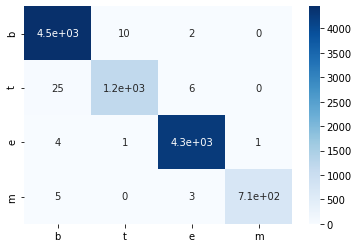

In [35]:
train_cm = confusion_matrix(train_x, train_t)
print('訓練データ')
print(train_cm)
show_cm(train_cm)

評価データ
[[516  13  12   6]
 [ 35  87  10   2]
 [ 22   2 531   3]
 [ 10   5   5  77]]


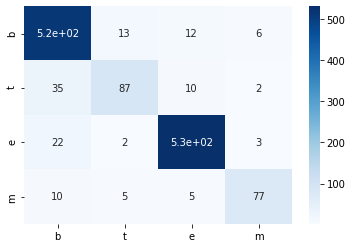

In [36]:
test_cm = confusion_matrix(test_x, test_t)
print('評価データ')
print(test_cm)
show_cm(test_cm)

### 56. 適合率，再現率，F1スコアの計測

In [37]:
tp = test_cm.diagonal()
tn = test_cm.sum(axis=1) - tp
fp = test_cm.sum(axis=0) - tp

In [38]:
p = tp / (tp + tn)
r = tp / (tp + fp)
F = 2 * p * r / (p + r)

In [39]:
micro_p = tp.sum() / (tp + tn).sum()
micro_r = tp.sum() / (tp + fp).sum()
micro_F = 2 * micro_p * micro_r / (micro_p + micro_r)
micro_ave = np.array([micro_p, micro_r, micro_F])

In [40]:
macro_p = p.mean()
macro_r = r.mean()
macro_F = 2 * macro_p * macro_r / (macro_p + macro_r)
macro_ave = np.array([macro_p, macro_r, macro_F])

In [41]:
table = np.array([p, r, F]).T
table = np.vstack([table, micro_ave, macro_ave])
pd.DataFrame(
    table,
    index = categories + ['マイクロ平均'] + ['マクロ平均'],
    columns = ['再現率', '適合率', 'F1スコア'])

,再現率,適合率,F1スコア
b,0.943327,0.885077,0.913274
t,0.649254,0.813084,0.721992
e,0.951613,0.951613,0.951613
m,0.793814,0.875000,0.832432
マイクロ平均,0.906437,0.906437,0.906437
マクロ平均,0.834502,0.881194,0.857212


### 57. 特徴量の重みの確認

In [42]:
def show_weight(directional, N):
    for i, cat in enumerate(categories):
        indices = lr.coef_[i].argsort()[::directional][:N]
        best = np.array(features)[indices]
        weight = lr.coef_[i][indices]
        print(category_names[i])
        display(pd.DataFrame([best, weight], index = ['特徴量', '重み'], columns = np.arange(N) + 1))

重みの高い特徴量トップ10

In [43]:
show_weight(-1, 10)

business


,1,2,3,4,5,6,7,8,9,10
特徴量,bank,fed,ukrain,yellen,china,ecb,fund,bond,profit,obamacar
重み,1.73804,1.62155,1.59007,1.51656,1.44616,1.42708,1.42298,1.35522,1.32754,1.31933


science and technology


,1,2,3,4,5,6,7,8,9,10
特徴量,facebook,googl,climat,appl,microsoft,nasa,fcc,activis,heartble,moon
重み,2.71298,2.6787,2.3076,2.23976,2.17365,1.79331,1.72819,1.67715,1.65323,1.52674


entertainment


,1,2,3,4,5,6,7,8,9,10
特徴量,kim,film,movi,chris,wed,fan,star,kim kardashian,transform,easter
重み,1.50072,1.47954,1.35987,1.28756,1.28378,1.24557,1.17424,1.16297,1.15932,1.1547


health


,1,2,3,4,5,6,7,8,9,10
特徴量,fda,cancer,mer,brain,ebola,doctor,studi,drug,medic,cdc
重み,1.94453,1.74533,1.73575,1.73243,1.65295,1.6509,1.60426,1.59458,1.55931,1.49178


重みの低い特徴量トップ10

In [44]:
show_weight(1, 10)

business


,1,2,3,4,5,6,7,8,9,10
特徴量,aereo,activis,babi,subscript,star,hat,victim,gentiva,virus,the ...
重み,-1.46757,-1.45666,-1.14729,-1.08675,-1.00507,-1.00284,-0.996877,-0.992272,-0.957667,-0.956004


science and technology


,1,2,3,4,5,6,7,8,9,10
特徴量,percent,drug,40,us stock,cancer,in ...,her,face,fed,well
重み,-0.943594,-0.896585,-0.880356,-0.811273,-0.81053,-0.804478,-0.7815,-0.765165,-0.763561,-0.751812


entertainment


,1,2,3,4,5,6,7,8,9,10
特徴量,googl,china,facebook,recal,rule,oil,price,studi,scientist,microsoft
重み,-1.42632,-1.3001,-1.18718,-1.12201,-1.07924,-1.04316,-1.03923,-1.02691,-0.982949,-0.953777


health


,1,2,3,4,5,6,7,8,9,10
特徴量,dimon,deal,facebook,ceo,gm,fund,climat,appl,hit,twitter
重み,-0.889664,-0.776552,-0.766138,-0.760696,-0.748344,-0.723219,-0.712452,-0.680762,-0.622121,-0.596804


### 58. 正則化パラメータの変更

In [45]:
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm import tqdm

/home/koyama.s/nlp100/env/nlp100/lib/python3.8/site-packages/japanize_matplotlib/__init__.py:13: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [46]:
Cs = np.arange(0.1, 5.1, 0.1)
lrs = [LogisticRegression(C=C, max_iter=1000).fit(train_x, train_t) for C in tqdm(Cs)]

100%|██████████| 50/50 [13:57<00:00, 16.74s/it]


In [47]:
train_accs = [accuracy(lr, train_x, train_t) for lr in lrs]
valid_accs = [accuracy(lr, valid_x, valid_t) for lr in lrs]
test_accs = [accuracy(lr, test_x, test_t) for lr in lrs]

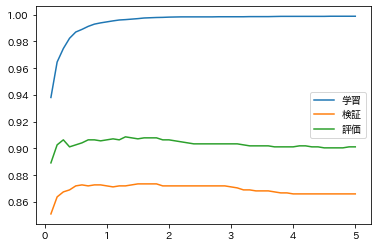

In [48]:
plt.plot(Cs, train_accs, label = '学習')
plt.plot(Cs, valid_accs, label = '検証')
plt.plot(Cs, test_accs, label = '評価')
plt.legend()
plt.savefig('result/58.png')

正則化が弱いと過学習してるのがわかる

### 59. ハイパーパラメータの探索

打ち切り誤差を変えて見る

In [49]:
tols = np.logspace(0, 2, 50)
lrs = [LogisticRegression(tol=tol, max_iter=1000).fit(train_x, train_t) for tol in tqdm(tols)]

100%|██████████| 50/50 [04:01<00:00,  4.83s/it]


In [50]:
train_accs = [accuracy(lr, train_x, train_t) for lr in lrs]
valid_accs = [accuracy(lr, valid_x, valid_t) for lr in lrs]
test_accs = [accuracy(lr, test_x, test_t) for lr in lrs]

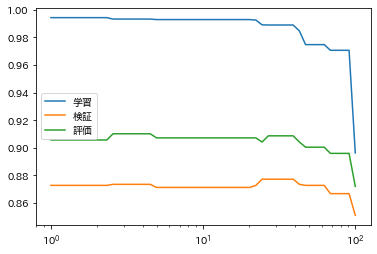

In [51]:
plt.plot(tols, train_accs, label = '学習')
plt.plot(tols, valid_accs, label = '検証')
plt.plot(tols, test_accs, label = '評価')
plt.xscale('log')
plt.legend()
plt.savefig('result/59.png')

sklearnの有名なフローチャートを見てなにかないかなという気持ちをする

<img src='https://scikit-learn.org/stable/_static/ml_map.png'>

ナイーブベイズ

In [52]:
from sklearn.naive_bayes import MultinomialNB

In [53]:
nb = MultinomialNB()
nb.fit(train_x, train_t)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [54]:
accuracy(nb, train_x, train_t)

0.9429988768251591

In [55]:
accuracy(nb, test_x, test_t)

0.8907185628742516

テキスト分類コスパ最強ナイーブベイズという感じ

サポートベクトルマシン

In [56]:
from sklearn.svm import LinearSVC

In [57]:
svc = LinearSVC(C=0.1)
svc.fit(train_x,train_t)

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [58]:
accuracy(svc, train_x, train_t)

0.9908274054661176

In [59]:
accuracy(svc, test_x, test_t)

0.9041916167664671

とてもいいですね